# Graph per Language

We analyze the graphs for every language to get insights into what can be a good idea to be used for feature engeneering later.

In [12]:
import pandas as pd
import networkx as nx
import ast
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
from sklearn.preprocessing import StandardScaler

In [3]:
train = pd.read_csv('../../data/train.csv')
train['edgelist'] = train['edgelist'].apply(ast.literal_eval)

### For each sentence, build a graph, compute degrees, and mark leaf nodes (degree == 1)

In [4]:
rows = []
for _, row in train.iterrows():
    lang = row['language']
    sent = row['sentence']
    root = row['root']
    edges = row['edgelist']
    G = nx.from_edgelist(edges)
    # degree dict: node -> degree
    deg = dict(G.degree())
    for node, d in deg.items():
        rows.append({
            'language': lang,
            'sentence': sent,
            'vertex': node,
            'is_leaf': (d == 1),
            'is_root': (node == root)
        })

node_df = pd.DataFrame(rows)

### Compute, for each language, the fraction of sentences whose root is a leaf

In [8]:
root_nodes = node_df[node_df['is_root']]
# Group by language
lang_stats = (
    root_nodes
    .groupby('language')['is_leaf']
    .agg(['mean', 'count'])
    .rename(columns={'mean': 'prop_root_is_leaf', 'count': 'n_sentences'})
    .reset_index()
    .sort_values(by='prop_root_is_leaf')
)

print(lang_stats)

      language  prop_root_is_leaf  n_sentences
7       German              0.000          500
3      English              0.002          500
5       French              0.008          500
18     Swedish              0.008          500
9    Icelandic              0.016          500
10  Indonesian              0.028          500
16     Russian              0.028          500
15  Portuguese              0.028          500
19        Thai              0.034          500
4      Finnish              0.036          500
17     Spanish              0.038          500
11     Italian              0.042          500
6     Galician              0.046          500
20     Turkish              0.050          500
2        Czech              0.056          500
0       Arabic              0.064          500
14      Polish              0.078          500
1      Chinese              0.088          500
13      Korean              0.088          500
8        Hindi              0.176          500
12    Japanes

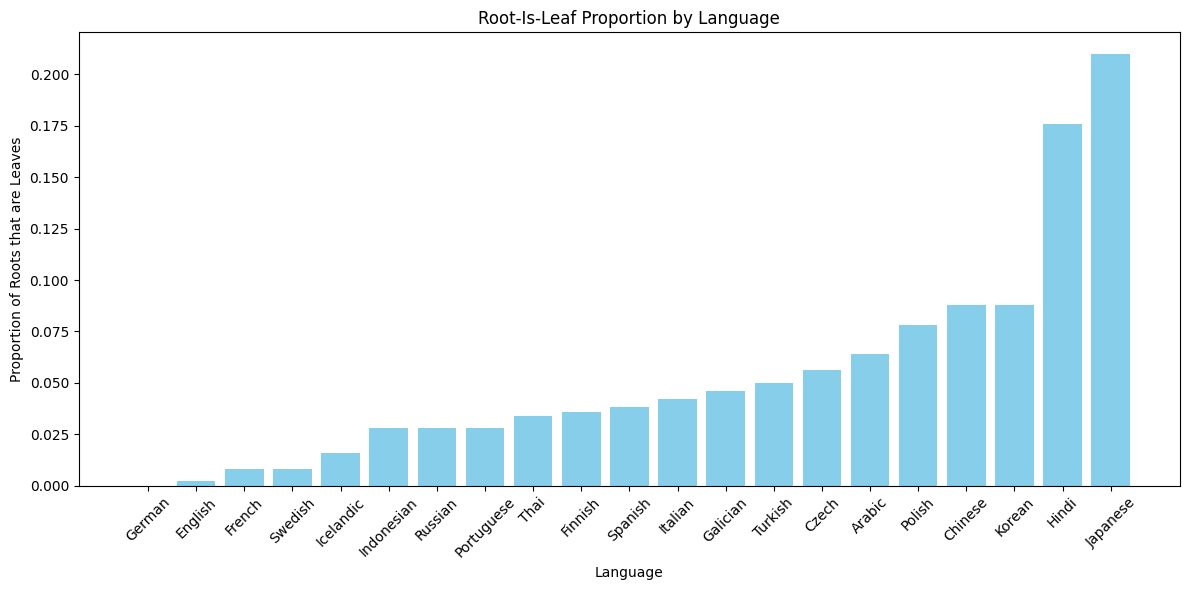

In [9]:
plt.figure(figsize=(12,6))
plt.bar(lang_stats['language'], lang_stats['prop_root_is_leaf'], color='skyblue')
plt.xticks(rotation=45)
plt.ylabel('Proportion of Roots that are Leaves')
plt.xlabel('Language')
plt.title('Root‐Is‐Leaf Proportion by Language')
plt.tight_layout()
plt.show()

## Other metrics

1. **Distance‐Based Features:** eccentricity, distance to tree center, min/max distance to leaves.
2. **Subtree‐Based Features:** subtree size stats and tree height if rooted at each node.
3. **Local Motifs & Degree Stats:** length‐2 path counts, neighbor‐degree statistics, neighbor‐degree entropy.
4. **Spectral Feature:** Fiedler vector entry from the Laplacian.
5. **Global Tree Metrics (joined):** diameter, radius, and balancedness.

In [10]:
# accumulate node features in a list
data_rows = []

In [13]:
for _, row in train.iterrows():
    lang = row.language
    sent = row.sentence
    root = row.root
    edges = row.edgelist
    T = nx.Graph(edges)
    n = T.number_of_nodes()

    # Precompute global metrics
    diam = nx.diameter(T)
    rad  = nx.radius(T)
    # For balancedness: longest path endpoints
    # Approx: pick one endpoint via eccentricity
    ecc = nx.eccentricity(T)
    far = max(ecc.items(), key=lambda x: x[1])[0]
    lengths = nx.single_source_shortest_path_length(T, far)
    other = max(lengths.items(), key=lambda x: x[1])[0]
    path = nx.shortest_path(T, far, other)
    # remove middle edge to split into two halves sizes
    mid = len(path)//2
    u, v = path[mid-1], path[mid]
    # copy graph and remove edge
    Gtmp = T.copy()
    Gtmp.remove_edge(u, v)
    comp = list(nx.connected_components(Gtmp))
    half_sizes = [len(c) for c in comp]
    bal = abs(half_sizes[0] - half_sizes[1]) / n

    # Leaves set
    leaves = {node for node,deg in T.degree() if deg==1}

    # Compute Laplacian Fiedler vector
    L = nx.laplacian_matrix(T).astype(float)
    # get 2nd smallest eigenvector
    try:
        from scipy.sparse.linalg import eigsh
        vals, vecs = eigsh(L, k=2, which='SM')
        fiedler = vecs[:,1]
    except Exception:
        fiedler = [0]*n

    # Degrees
    deg_dict = dict(T.degree())

    # For each node
    for node in T.nodes():
        # distances
        dist = dict(nx.single_source_shortest_path_length(T, node))
        ecc_n = ecc[node]
        # distance to center(s)
        centers = nx.center(T)
        d_center = min(nx.shortest_path_length(T, node, c) for c in centers)
        # leaf distances
        d_leaf = [dist[l] for l in leaves]
        min_leaf = min(d_leaf)
        max_leaf = max(d_leaf)
        # subtree sizes: for each neighbor, size of component when removing edge
        neigh = list(T.neighbors(node))
        sub_sizes = []
        for nbr in neigh:
            G2 = T.copy()
            G2.remove_edge(node, nbr)
            # component containing nbr
            comp_n = [c for c in nx.connected_components(G2) if nbr in c][0]
            sub_sizes.append(len(comp_n))
        # tree height
        height = max(dist.values())
        # length-2 paths through node = sum(deg(neighbor)-1)
        path2 = sum(deg_dict[nbr]-1 for nbr in neigh)
        # neighbor-degree stats
        nbr_degs = [deg_dict[n] for n in neigh]
        nbr_deg_mean = np.mean(nbr_degs) if neigh else 0
        nbr_deg_max  = np.max(nbr_degs) if neigh else 0
        nbr_deg_min  = np.min(nbr_degs) if neigh else 0
        # neighbor-degree entropy
        counts = np.bincount(nbr_degs)
        e_nbr = entropy(counts[counts>0])
        # fiedler entry for this node
        f_val = fiedler[list(T.nodes()).index(node)] if len(fiedler)>list(T.nodes()).index(node) else 0

        data_rows.append({
            'language': lang,
            'sentence': sent,
            'vertex': node,
            'is_root': node==root,
            'degree': deg_dict[node],
            'eccentricity': ecc_n,
            'dist_center': d_center,
            'min_leaf_dist': min_leaf,
            'max_leaf_dist': max_leaf,
            'sub_max': max(sub_sizes) if sub_sizes else 0,
            'sub_min': min(sub_sizes) if sub_sizes else 0,
            'sub_var': np.var(sub_sizes) if sub_sizes else 0,
            'height_if_root': height,
            'path2': path2,
            'nbr_deg_mean': nbr_deg_mean,
            'nbr_deg_max': nbr_deg_max,
            'nbr_deg_min': nbr_deg_min,
            'nbr_deg_entropy': e_nbr,
            'fiedler': f_val,
            'diameter': diam,
            'radius': rad,
            'balancedness': bal
        })

node_feats = pd.DataFrame(data_rows)

In [19]:
features = [
    'eccentricity',
    'dist_center',
    'min_leaf_dist',
    'sub_max',
    'height_if_root'
]

In [22]:
# all languages in order
langs = sorted(node_feats['language'].unique())

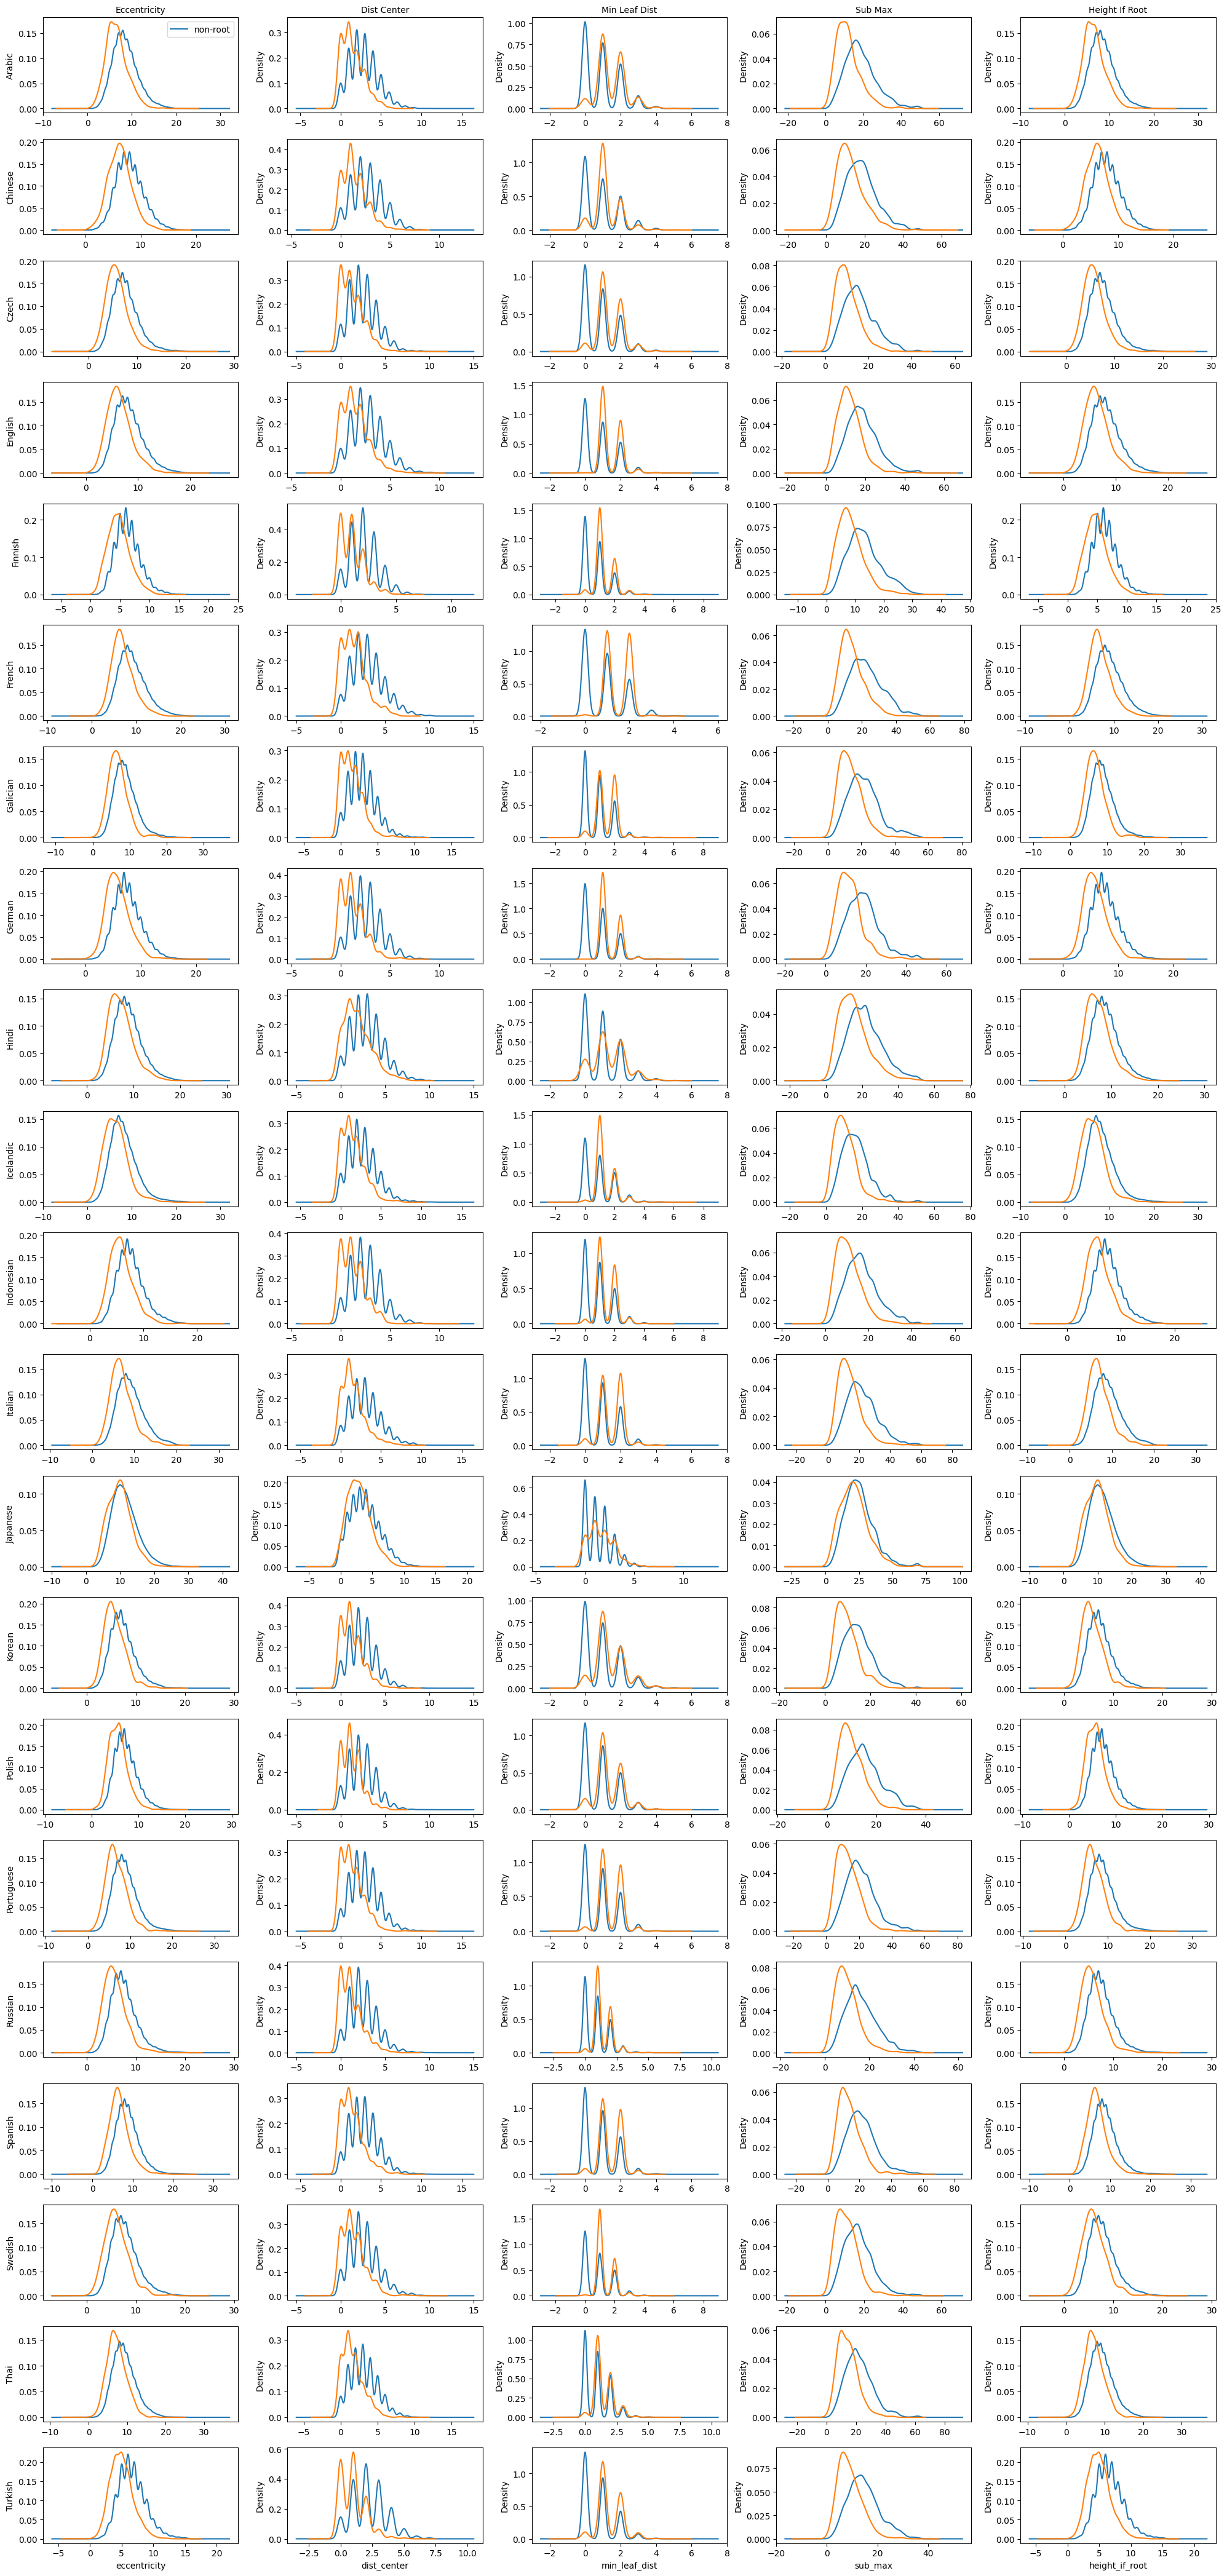

In [26]:
fig, axes = plt.subplots(
    nrows=len(langs),
    ncols=len(features),
    figsize=(4*len(features), 2*len(langs)),
    sharex=False,   # each column can have its own x-scale
    sharey=False    # each plot gets its own y-scale
)

for i, lang in enumerate(langs):
    df_lang = node_feats[node_feats['language'] == lang]
    for j, feat in enumerate(features):
        ax = axes[i, j]
        # plot non-root
        df_lang[df_lang['is_root'] == False][feat].plot(
            kind='kde', ax=ax, label='non-root', legend=(i==0 and j==0)
        )
        # plot root
        df_lang[df_lang['is_root'] == True][feat].plot(
            kind='kde', ax=ax, label='root', legend=False
        )
        # titles on top row only
        if i == 0:
            ax.set_title(feat.replace('_', ' ').title(), fontsize=10)
        # language labels on leftmost column
        if j == 0:
            ax.set_ylabel(lang, fontsize=10)
        # x-labels on bottom row only
        if i == len(langs) - 1:
            ax.set_xlabel(feat, fontsize=10)

plt.tight_layout(h_pad=1.0, w_pad=0.5)
plt.show()